Typing Performance Dashboard
Files used:`results.csv` (our dataset for this)

This notebook generates a set of plots useful for a data-analytics dashboard for your typing dataset:
- Speed (WPM) over time
- Accuracy over time
- Speed vs Accuracy (correlation)
- Raw WPM vs Final WPM comparison
- Consistency over time
- Histogram (WPM distribution)
- Rolling average (moving average)
- Average speed by mode (bar chart)


In [6]:
# 1) Imports and load data
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# Loading data
df = pd.read_csv("results.csv")

# Convert timestamp (milliseconds) to datetime and sort
df['time'] = pd.to_datetime(df['timestamp'], unit='ms')
df = df.sort_values('time').reset_index(drop=True)

# Quick peek
print('Rows, cols:', df.shape)
display(df.head())


Rows, cols: (1000, 25)


,_id,isPb,wpm,acc,rawWpm,consistency,charStats,mode,mode2,quoteLength,...,numbers,language,funbox,difficulty,lazyMode,blindMode,bailedOut,tags,timestamp,time
0,68e8cd8dc2c5004cd4fddc67,NaN,59.6,86.63,65.6,67.47,149;0;1;2,time,30,-1,...,False,english,NaN,normal,False,False,False,NaN,1760087437000,2025-10-10 09:10:37
1,68e8cdadc2c5004cd4fdddc7,NaN,66.8,93.37,66.8,65.38,167;0;0;0,time,30,-1,...,False,english,NaN,normal,False,False,False,NaN,1760087469000,2025-10-10 09:11:09
2,68e8cdeec2c5004cd4fde026,NaN,79.6,92.11,87.6,72.28,199;5;0;2,time,30,-1,...,False,english,NaN,normal,False,False,False,NaN,1760087534000,2025-10-10 09:12:14
3,68e8ce7ec2c5004cd4fde569,NaN,63.2,90.00,81.6,64.06,158;6;3;2,time,30,-1,...,False,english,NaN,normal,False,False,False,NaN,1760087678000,2025-10-10 09:14:38
4,68e8ceefc2c5004cd4fde9c8,NaN,67.2,92.75,74.0,62.43,168;3;0;2,time,30,-1,...,False,english,NaN,normal,False,False,False,NaN,1760087791000,2025-10-10 09:16:31


In [3]:
# 2) Basic descriptive statistics
display(df[['wpm','rawWpm','acc','consistency']].describe())


,wpm,rawWpm,acc,consistency
count,1000.00000,1000.000000,1000.000000,1000.000000
mean,72.98232,78.442680,92.124740,64.695980
std,11.81078,13.808017,3.508161,7.196712
min,39.60000,42.000000,78.180000,35.770000
25%,65.60000,70.000000,90.147500,60.567500
50%,71.19000,75.600000,92.540000,64.255000
75%,77.99000,82.842500,94.342500,68.440000
max,130.69000,135.030000,100.000000,98.020000


The purpose of the compressed axis is to visualize performance trends without distortion from irregular sampling intervals

Total typing tests in dataset: 1000


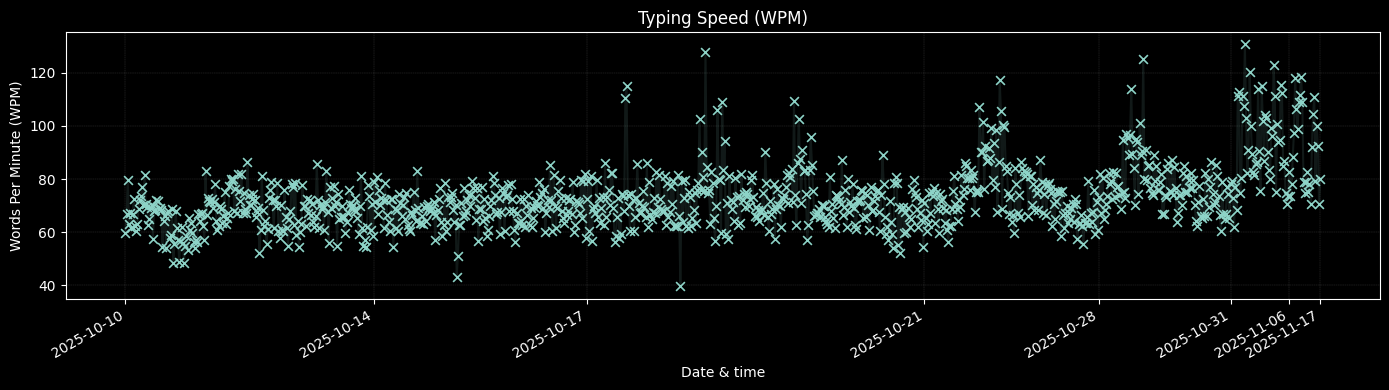

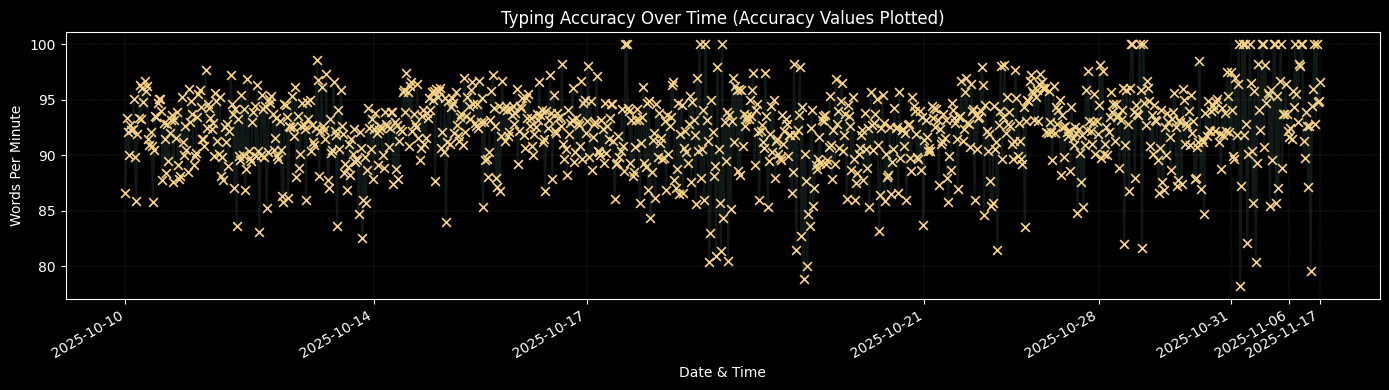

In [19]:
# convert timestamps in ms → datetime
df["time"] = pd.to_datetime(df["timestamp"], unit="ms", errors="coerce")

# drop any failed conversions (just in case)
df = df.dropna(subset=["time"]).sort_values("time").reset_index(drop=True)

# add a date-only column (helps for labeling axis)
df["date_only"] = df["time"].dt.date

print(f"Total typing tests in dataset: {len(df)}")


temp = df.reset_index()[["index", "date_only"]]

# For each date, get the FIRST test's index
first_idx_per_date = (
    temp.groupby("date_only", sort=True)["index"]
        .min()
        .reset_index()
        .rename(columns={"index": "first_idx"})
)

# sample max 10 ticks to avoid clutter
max_ticks = 8
if len(first_idx_per_date) > max_ticks:
    pick_positions = np.linspace(0, len(first_idx_per_date)-1, max_ticks, dtype=int)
    sampled = first_idx_per_date.iloc[pick_positions]
else:
    sampled = first_idx_per_date

tick_positions = sampled["first_idx"].tolist()
tick_labels = [d.strftime("%Y-%m-%d") for d in sampled["date_only"]]


plt.figure(figsize=(14, 4))


# show every test as an 'x'
plt.scatter(df.index, df["wpm"], marker="x", s=40, linewidths=1.2)

# faint connecting line just for readability
plt.plot(df.index, df["wpm"], alpha=0.12)

# unique date ticks only
plt.xticks(tick_positions, tick_labels, rotation=30, ha="right")

plt.xlabel("Date & time")
plt.ylabel("Words Per Minute (WPM)")
plt.title("Typing Speed (WPM)")
plt.grid(True, linestyle="--", linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 4))
# plt.style.use("dark_background")

plt.scatter(df.index, df["acc"], marker="x", s=40, linewidths=1.2, color="#ffd27f")
plt.plot(df.index, df["acc"], alpha=0.12)

plt.xticks(tick_positions, tick_labels, rotation=30, ha="right")

plt.xlabel("Date & Time")
plt.ylabel("Words Per Minute")
plt.title("Typing Accuracy Over Time (Accuracy Values Plotted)")
plt.grid(True, linestyle="--", linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()



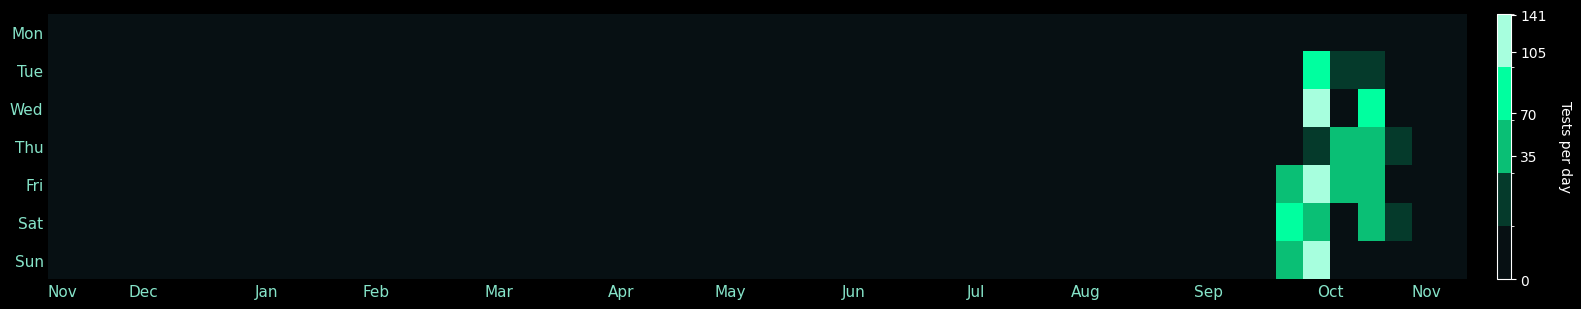

Saved static heatmap to: typing_heatmap.png


In [7]:
from matplotlib import colors
from datetime import timedelta

out_path = "typing_heatmap.png"
weeks_back = 52

df['time'] = pd.to_datetime(df['timestamp'], unit='ms', errors='coerce')
df = df.dropna(subset=['time']).sort_values('time').reset_index(drop=True)

last_day = df['time'].max().normalize()
end_sunday = last_day + pd.Timedelta(days=(6 - last_day.weekday()))
start_monday = end_sunday - pd.Timedelta(weeks=weeks_back) + pd.Timedelta(days=1)
all_dates = pd.date_range(start=start_monday, end=end_sunday, freq='D')

df['date'] = df['time'].dt.floor('D')
counts = df.groupby('date').size().rename('count').reset_index()
cal = pd.DataFrame({'date': all_dates}).merge(counts, on='date', how='left').fillna(0)
cal['count'] = cal['count'].astype(int)
cal['weekday'] = cal['date'].dt.weekday
cal['week_index'] = ((cal['date'] - start_monday).dt.days // 7).astype(int)

grid = np.zeros((7, weeks_back), dtype=int)
for _, r in cal.iterrows():
    w = int(r['week_index'])
    d = int(r['weekday'])
    if 0 <= w < weeks_back and 0 <= d < 7:
        grid[d, w] = int(r['count'])

# discrete palette (5 levels)
nonzero = grid[grid>0]
if nonzero.size>0:
    p25,p50,p75,p90 = np.percentile(nonzero, [25,50,75,90])
    thresholds = [0, max(1,int(p25)), max(2,int(p50)), max(3,int(p75)), max(4,int(p90)), grid.max()+1]
else:
    thresholds=[0,1,2,3,4,5]
colors_list=["#071013","#053a2b","#0abf75","#00ff9f","#a7ffde"]
cmap = colors.ListedColormap(colors_list)
norm = colors.BoundaryNorm(thresholds, cmap.N, clip=True)

fig, ax = plt.subplots(figsize=(16,3.2))
plt.style.use('dark_background')
im = ax.imshow(grid, origin='upper', aspect='auto', cmap=cmap, norm=norm, interpolation='nearest')

# full weekday labels (Mon..Sun) on left
ax.set_yticks(range(7))
ax.set_yticklabels(['Mon','Tue','Wed','Thu','Fri','Sat','Sun'], color='#86e4c9', fontsize=11)

# month labels
week_starts = [start_monday + pd.Timedelta(weeks=i) for i in range(weeks_back)]
week_months = [w.strftime("%b") for w in week_starts]
month_positions=[]
month_labels=[]
cur = week_months[0]
seg_start=0
for i,m in enumerate(week_months+["__end__"]):
    if m!=cur:
        center=(seg_start+(i-1))/2.0
        month_positions.append(center)
        month_labels.append(cur)
        cur=m
        seg_start=i
if month_positions:
    ax.set_xticks(month_positions)
    ax.set_xticklabels(month_labels, color='#86e4c9', fontsize=11)

# aesthetics
for spine in ax.spines.values():
    spine.set_visible(False)
ax.tick_params(axis='x', length=0)
ax.tick_params(axis='y', length=0)

cbar = plt.colorbar(im, ax=ax, fraction=0.035, pad=0.02)
cbar.set_label("Tests per day", rotation=270, labelpad=18)
# integer ticks if small range
mx = grid.max()
if mx<=8:
    cbar.set_ticks(range(0,mx+1))
else:
    cbar.set_ticks(np.linspace(0,mx,5).astype(int))
plt.tight_layout()
plt.savefig(out_path, dpi=300, bbox_inches='tight', pad_inches=0.1)
plt.show()
print("Saved static heatmap to:", out_path)


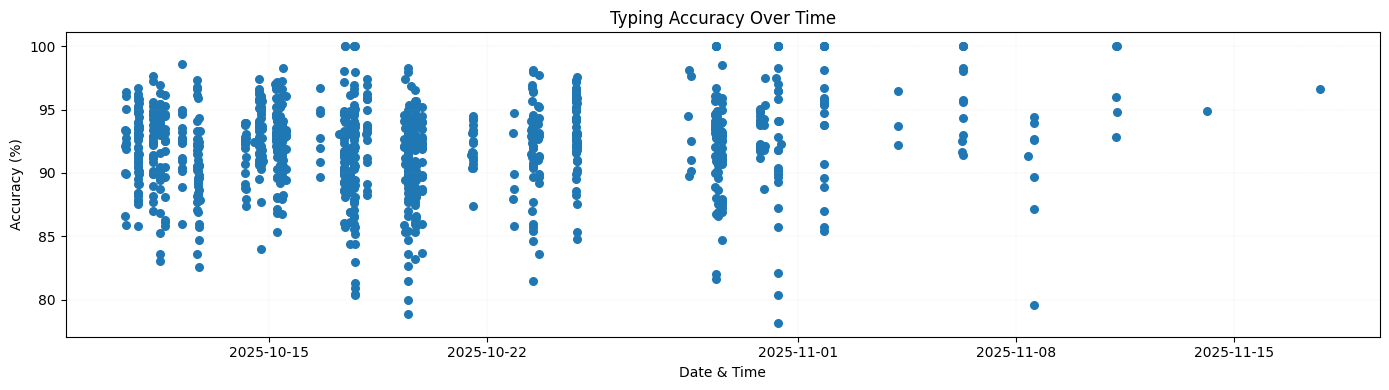

In [13]:
# 4) Accuracy (%) over time
plt.figure(figsize=(14,4))
plt.scatter(df['time'], df['acc'], marker='o', s=30)
plt.xlabel('Date & Time')
plt.ylabel('Accuracy (%)')
plt.title('Typing Accuracy Over Time')
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()


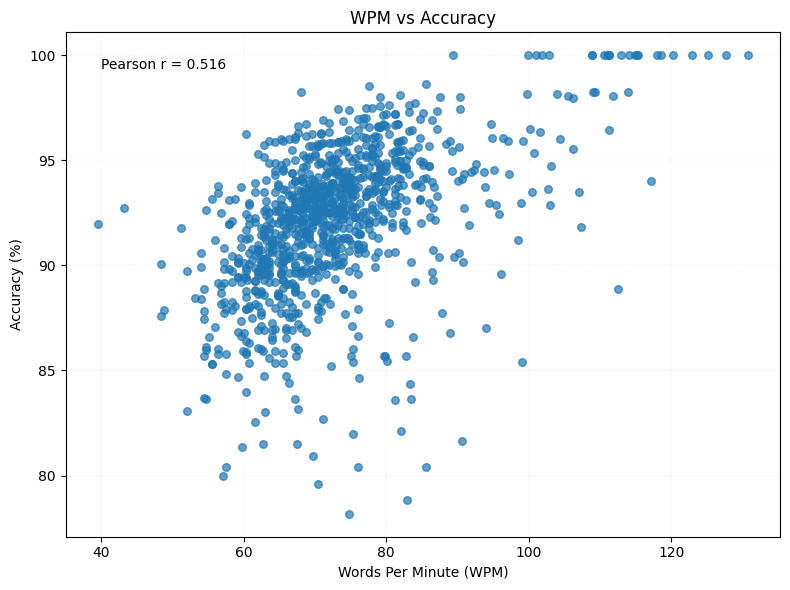

In [15]:
# 5) Speed vs Accuracy (Correlation)
plt.figure(figsize=(8,6))
plt.scatter(df['wpm'], df['acc'], s=30, alpha=0.7)
plt.xlabel('Words Per Minute (WPM)')
plt.ylabel('Accuracy (%)')
plt.title('WPM vs Accuracy')
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
# Pearson correlation
corr = df['wpm'].corr(df['acc'])
plt.annotate(f'Pearson r = {corr:.3f}', xy=(0.05, 0.95), xycoords='axes fraction',
             fontsize=10, verticalalignment='top')
plt.tight_layout()
plt.show()


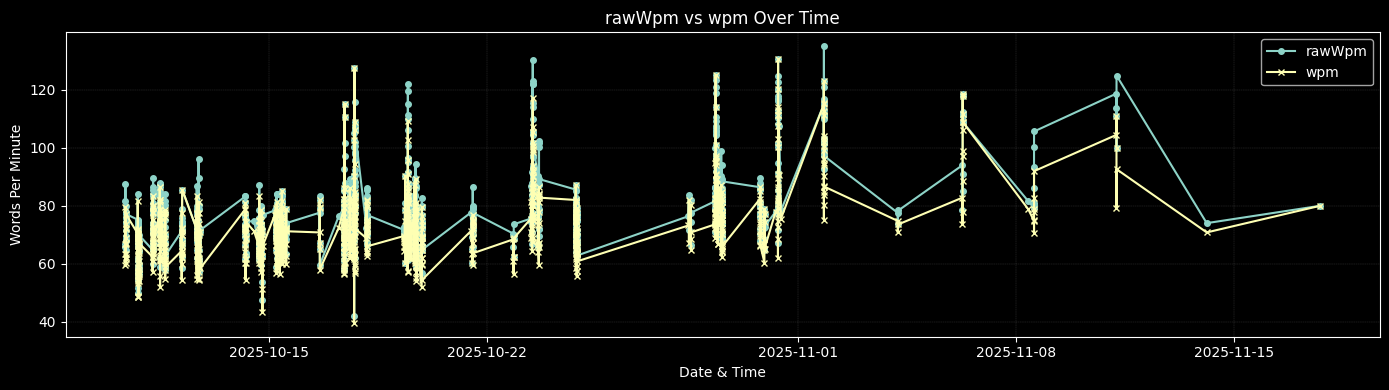

In [10]:
# 6) Raw WPM vs Final WPM comparison
plt.figure(figsize=(14,4))
plt.plot(df['time'], df['rawWpm'], marker='o', linestyle='-', label='rawWpm', markersize=4)
plt.plot(df['time'], df['wpm'], marker='x', linestyle='-', label='wpm', markersize=4)
plt.xlabel('Date & Time')
plt.ylabel('Words Per Minute')
plt.title('rawWpm vs wpm Over Time')
plt.legend()
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()


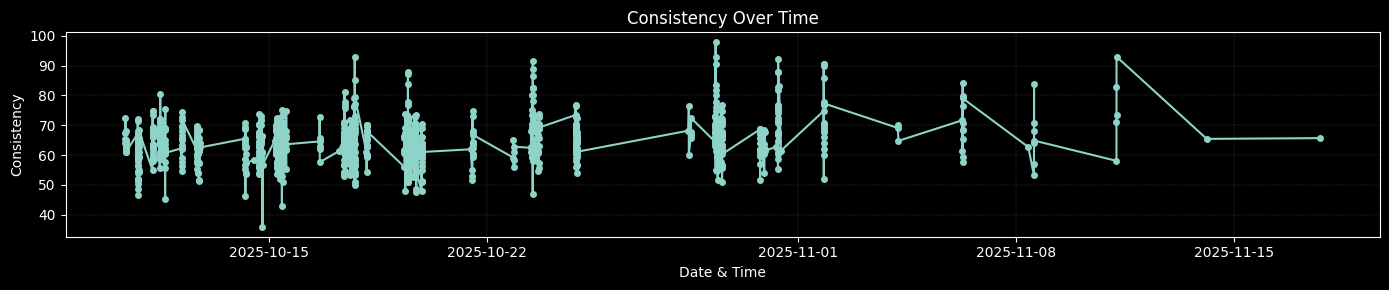

In [8]:
# 7) Consistency over time
if 'consistency' in df.columns:
    plt.figure(figsize=(14,3))
    plt.plot(df['time'], df['consistency'], marker='o', markersize=4)
    plt.xlabel('Date & Time')
    plt.ylabel('Consistency')
    plt.title('Consistency Over Time')

    plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
    plt.tight_layout()
    plt.show()
else:
    print('No consistency column found in dataset.')


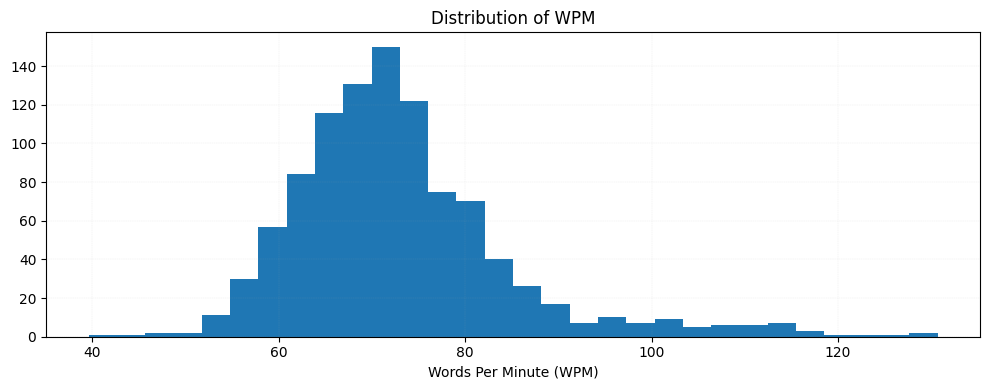

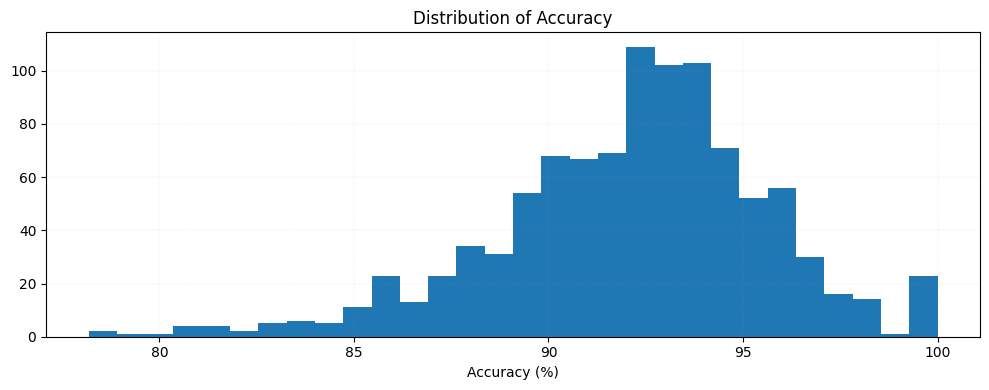

In [18]:
# 8) Distribution / Histogram of WPM & Accuracy
plt.figure(figsize=(10,4))
plt.hist(df['wpm'].dropna(), bins=30)
plt.xlabel('Words Per Minute (WPM)')
plt.title('Distribution of WPM')
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.hist(df['acc'].dropna(), bins=30)
plt.xlabel('Accuracy (%)')
plt.title('Distribution of Accuracy')
plt.grid(True, linestyle='--', linewidth=0.3, alpha=0.25)
plt.tight_layout()
plt.show()


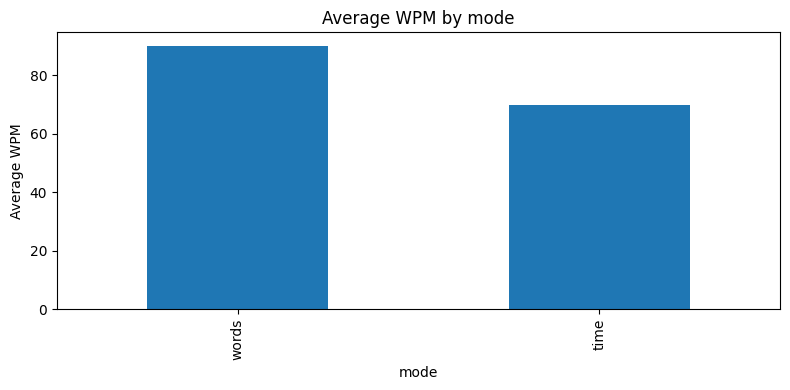

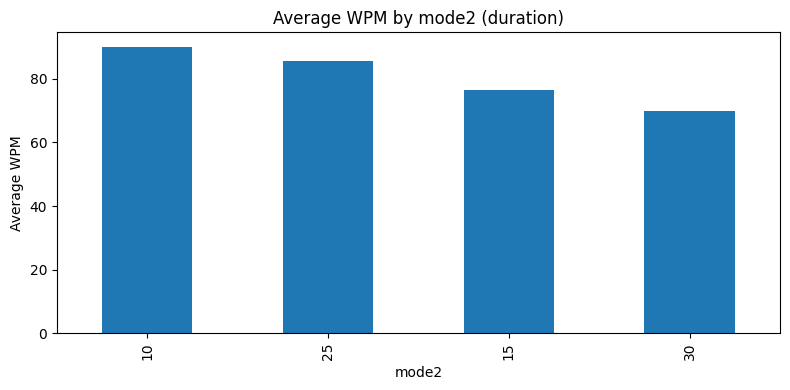

In [19]:
# 9) Average speed by mode and mode2 (if available)
if 'mode' in df.columns:
    by_mode = df.groupby('mode')['wpm'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    by_mode.plot(kind='bar')
    plt.ylabel('Average WPM')
    plt.title('Average WPM by mode')
    plt.tight_layout()
    plt.show()
else:
    print('mode column not found.')

if 'mode2' in df.columns:
    by_mode2 = df.groupby('mode2')['wpm'].mean().sort_values(ascending=False)
    plt.figure(figsize=(8,4))
    by_mode2.plot(kind='bar')
    plt.ylabel('Average WPM')
    plt.title('Average WPM by mode2 (duration)')
    plt.tight_layout()
    plt.show()
else:
    print('mode2 column not found.')


In [21]:
# 10) Quick summary metrics and export
summary = {
    'total_tests': len(df),
    'mean_wpm': df['wpm'].mean(),
    'median_wpm': df['wpm'].median(),
    'mean_accuracy': df['acc'].mean(),
    'median_accuracy': df['acc'].median(),
    'mean_consistency': df['consistency'].mean() if 'consistency' in df.columns else None
}
print(summary)

# Save summarized table per-day
df['date'] = df['time'].dt.date
daily = df.groupby('date').agg({
    'wpm': ['mean','median','count'],
    'acc': ['mean','median']
})
daily.to_csv('daily_summary.csv')
print('Saved daily_summary.csv (per-day aggregates)')
display(daily.head())


{'total_tests': 1000, 'mean_wpm': np.float64(72.98231999999999), 'median_wpm': np.float64(71.19), 'mean_accuracy': np.float64(92.12474), 'median_accuracy': np.float64(92.54), 'mean_consistency': np.float64(64.69597999999999)}
Saved daily_summary.csv (per-day aggregates)


wpm                     acc        
                 mean median count       mean  median
date                                                 
2025-10-10  63.777231   64.4    65  92.170923  92.620
2025-10-11  69.440759   69.2    79  91.815949  92.510
2025-10-12  67.530156   68.2    64  91.093438  91.335
2025-10-14  67.747600   68.4    75  92.809067  92.750
2025-10-15  69.677083   70.0    96  92.862813  93.190